In [49]:
# Import EDA Statements

import pandas as pd
import seaborn as sns
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
sns.set_theme()

In [50]:
df = pd.read_csv('Video_Games_Sales_as_at_22_Dec_2016.csv')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16719 entries, 0 to 16718
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16717 non-null  object 
 1   Platform         16719 non-null  object 
 2   Year_of_Release  16450 non-null  float64
 3   Genre            16717 non-null  object 
 4   Publisher        16665 non-null  object 
 5   NA_Sales         16719 non-null  float64
 6   EU_Sales         16719 non-null  float64
 7   JP_Sales         16719 non-null  float64
 8   Other_Sales      16719 non-null  float64
 9   Global_Sales     16719 non-null  float64
 10  Critic_Score     8137 non-null   float64
 11  Critic_Count     8137 non-null   float64
 12  User_Score       10015 non-null  object 
 13  User_Count       7590 non-null   float64
 14  Developer        10096 non-null  object 
 15  Rating           9950 non-null   object 
dtypes: float64(9), object(7)
memory usage: 2.0+ MB


,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8,322.0,Nintendo,E
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,NaN,NaN,NaN,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8,192.0,Nintendo,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,NaN,NaN,NaN,NaN,NaN,NaN


In [51]:
df['User_Score'].replace('tbd', None, inplace=True)
df['User_Score'] = df['User_Score'].astype('float64')
df['Year_of_Release'] = df['Year_of_Release'].astype('Int64')
df.dropna(subset=['Name'], inplace=True)

df = df[df['Year_of_Release'] <= 2016]  # Empty data

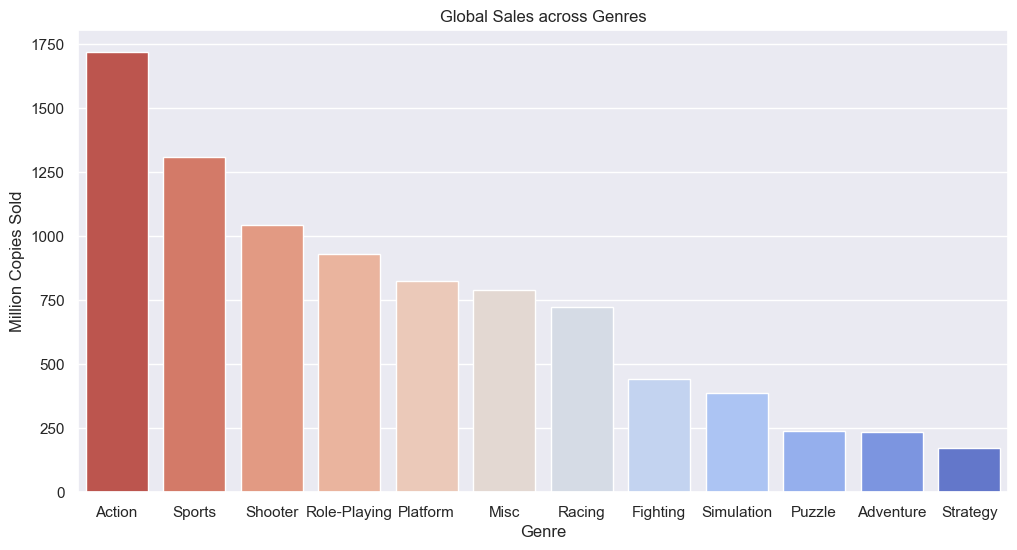

In [52]:
Sales_df = df.groupby('Genre')[['Global_Sales']].sum()
Sales_df = Sales_df.sort_values(by='Global_Sales', ascending=False)

plt.figure(figsize=(12, 6))
plt.title('Global Sales across Genres')
plt.ylabel('Million Copies Sold')
sns.barplot(data= Sales_df, x='Genre' , y= 'Global_Sales', palette="coolwarm_r")
plt.show()

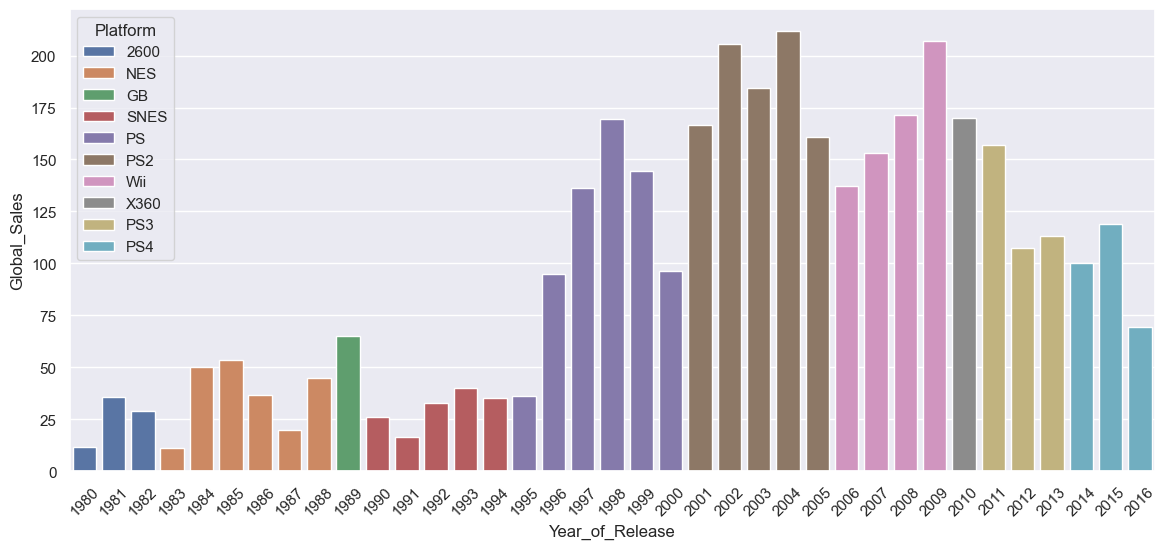

In [53]:
Plat_df = df.groupby(['Year_of_Release', 'Platform'])['Global_Sales'].sum().reset_index()
leaders = Plat_df.loc[Plat_df.groupby('Year_of_Release')['Global_Sales'].idxmax()]

plt.figure(figsize=(14, 6))
sns.barplot(data=leaders, x='Year_of_Release', y='Global_Sales', hue='Platform')
plt.xticks(rotation=45)
plt.show()

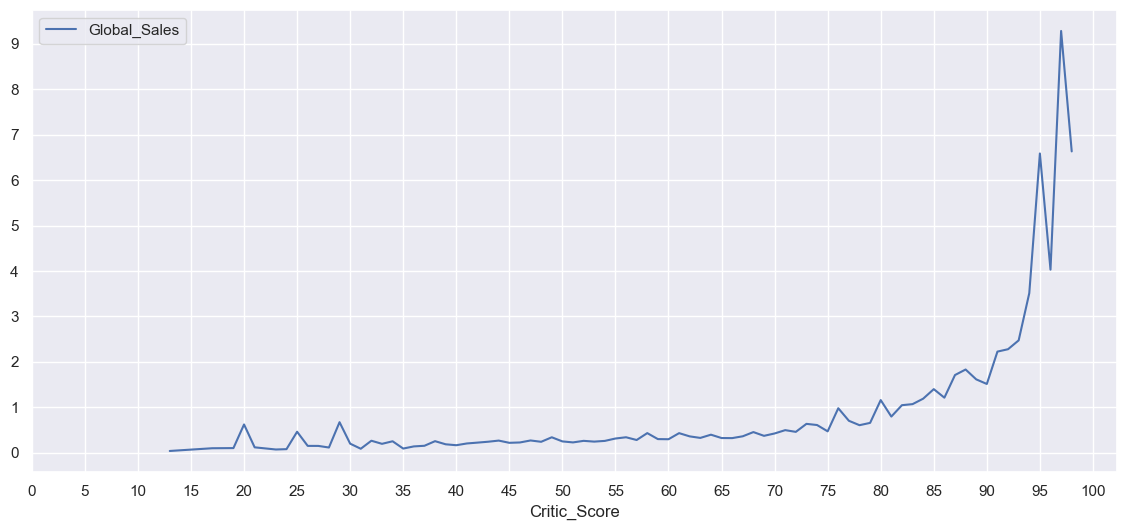

In [54]:
Critic_df = df.groupby('Critic_Score')[['Global_Sales']].mean()

plt.figure(figsize=(14, 6))
sns.lineplot(Critic_df)
plt.xticks(range(0, 101, 5))
plt.yticks(range(0, int(Critic_df['Global_Sales'].max())+1, 1))
plt.show()

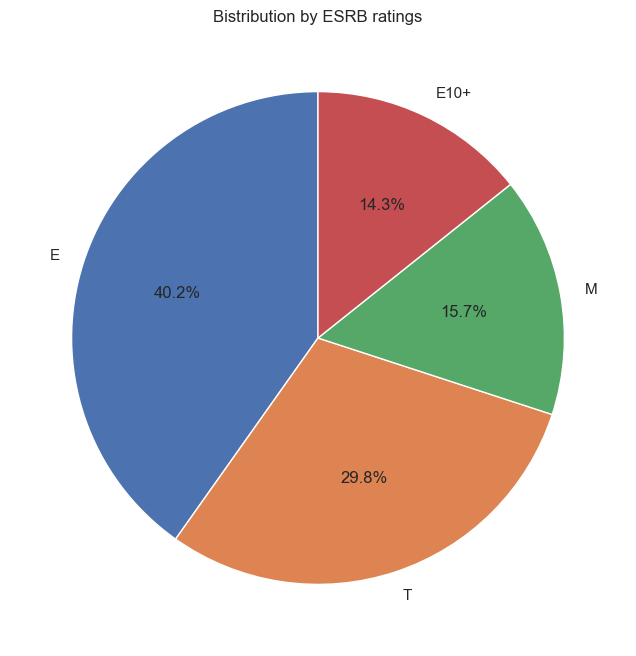

In [55]:
filtered_df = df[df["Rating"].isin(["E", "T", "M", "E10+"])]
filtered_df["Rating"].value_counts().plot(
    kind="pie", autopct="%1.1f%%", figsize=(8,8), startangle=90)
plt.title("Вistribution by ESRB ratings")
plt.ylabel(None)
plt.show()


In [56]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder


X = df[['Platform', 'Year_of_Release', 'Genre', 'Critic_Score', 'Critic_Count', 'User_Score', 'User_Count', 'Rating']]
y = df['Global_Sales']

df.Rating = df.Rating.fillna('E')
X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state=0)

categorical_cols = [cname for cname in X_train.columns if X_train[cname].dtype == "object"]

numerical_cols = [cname for cname in X_train.columns if X_train[cname].dtype in ['Int64', 'float64']]

numerical_transformer = SimpleImputer(strategy='constant')

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OrdinalEncoder())
])

preprocessor = ColumnTransformer(
    transformers=[
('num', numerical_transformer, numerical_cols),
('cat', categorical_transformer, categorical_cols)
    ])



In [57]:
# Custom Data
data1 = {
    'Platform': ['PC'],
    'Year_of_Release' : [2010],
    'Genre' : ['Adventure'],
    'Critic_Score' : [79.0],
    'Critic_Count' : [100.0],
    'User_Score' : [94.0],
    'User_Count' : [100.0],
    'Rating' : ['T']
}

In [58]:
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, r2_score

model = XGBRegressor(n_estimators=70, learning_rate=0.1, n_jobs=4)

my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', model)])

# Training the model
my_pipeline.fit(X_train, y_train)

# Preprocessing of validation data, get predictions
preds = my_pipeline.predict(X_valid)

score = mean_absolute_error(y_valid, preds)
r2 = r2_score(y_valid, preds)
print('MAE: %.4f ' %score)
print('R2: %.4f ' %r2)

# MAE: 0.4273 
# R2: 0.2807


MAE: 0.4273 
R2: 0.2807 


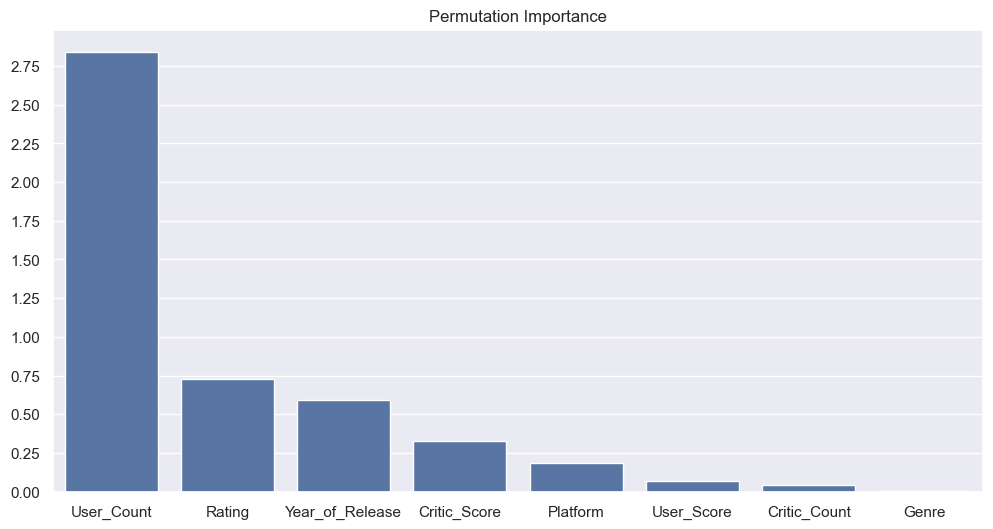

In [ ]:
from sklearn.inspection import permutation_importance
import numpy as np

result = permutation_importance(my_pipeline, X_valid, y_valid, n_repeats=10, random_state=0)

perm_importances = pd.Series(result.importances_mean, index=X_valid.columns)
perm_importances.sort_values(ascending=False, inplace=True)
plt.figure(figsize=(12,6))
plt.yticks(np.arange(0, 3, 0.25))
sns.barplot(perm_importances)
plt.title("Permutation Importance")
plt.show()
